## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data and all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import load_img
from glob import glob

This project involves working with a dataset comprising approximately 2,357 images of various skin cancer types. The dataset is organized into training and testing sets, each containing nine subdirectories. Each subdirectory corresponds to a specific type of skin cancer and holds relevant image samples. The objective is to build a model capable of accurately classifying these images into their respective categories.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/Users/RYZEN/Desktop/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/Users/RYZEN/Desktop/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [3]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset
Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180   

Use 80% of the images for training, and 20% for validation.

In [5]:
# Create train dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
# Create validation dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

Found 2239 files belonging to 9 classes.


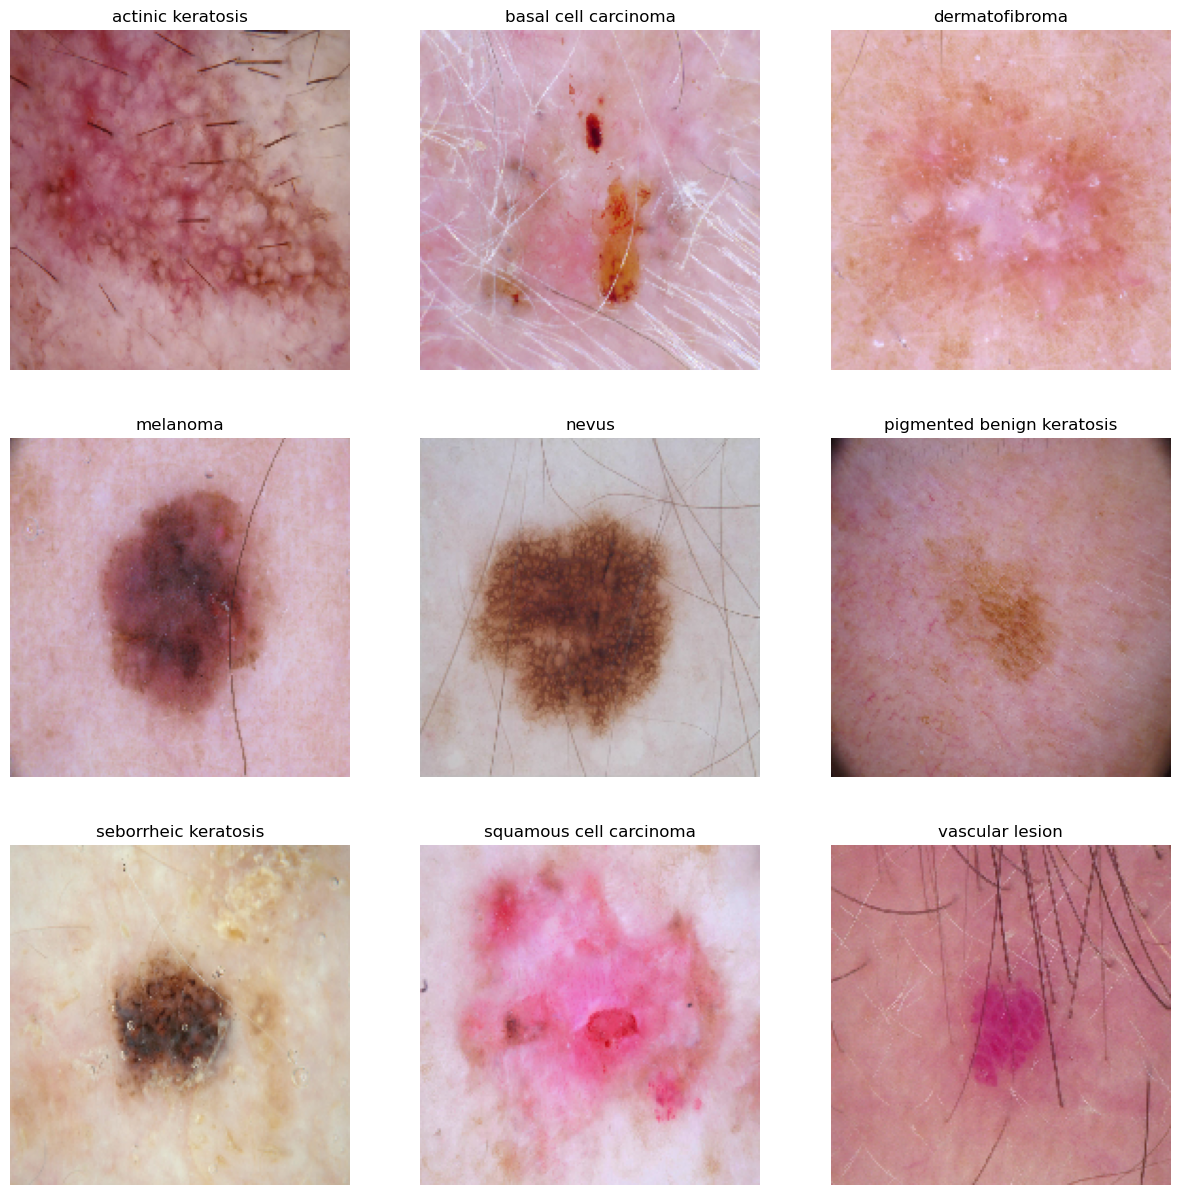

In [8]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Total number of images based on the class / cateogories.
def class_distribution_count(directory):
    """
    Counts the number of images in each class within a given directory.

    Args:
        directory (str): Path to the directory containing class subdirectories.

    Returns:
        pd.DataFrame: A DataFrame containing class names and their corresponding image counts.
    """
    # Initialize lists for storing class names and image counts
    class_names = []
    image_counts = []

    # Iterate through the subdirectories
    for subdir in pathlib.Path(directory).iterdir():
        if subdir.is_dir():  # Check if it's a directory
            class_names.append(subdir.name)  # Store the class name (directory name)
            image_counts.append(len(list(subdir.glob("*.*"))))  # Count image files in the subdirectory

    # Return the data as a pandas DataFrame
    return pd.DataFrame({"Class": class_names, "No. of Images": image_counts})

# Example usage
df = class_distribution_count(data_dir_train)
df.head(10)

,Class,No. of Images
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


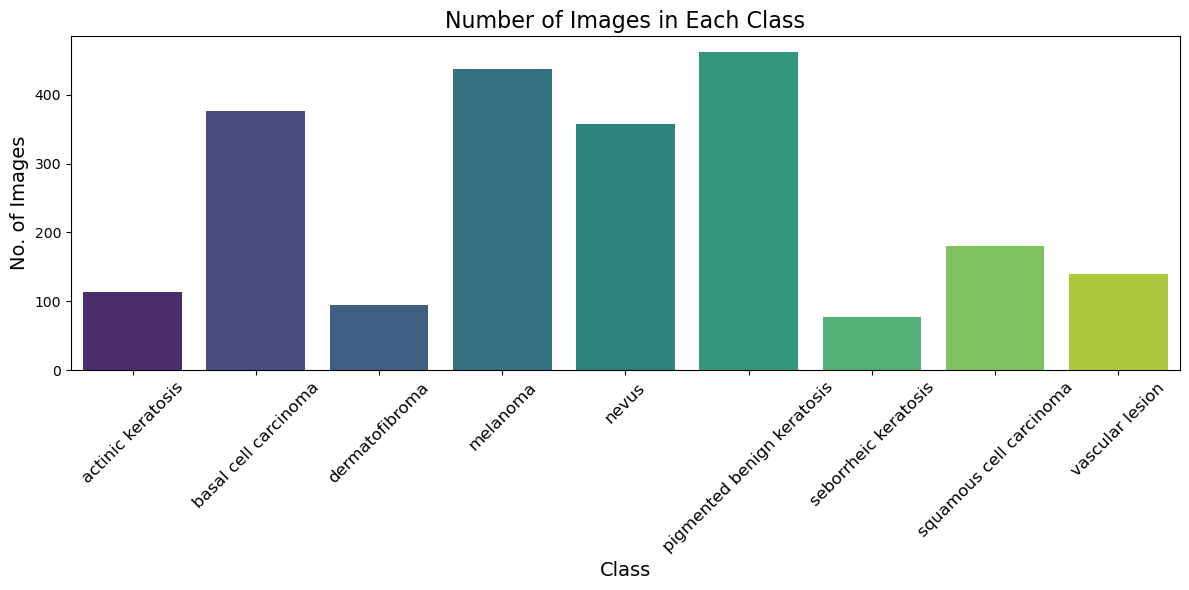

In [11]:
# Visualize the number of images in each class as a vertical bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="No. of Images", hue="Class", data=df, palette="viridis", dodge=False)
plt.title("Number of Images in Each Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("No. of Images", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate class names for better visibility
plt.legend([], [], frameon=False)  # Remove the legend since hue is redundant
plt.tight_layout()
plt.show() 

### Create the model

In [12]:
target_classes = 9 

# Build CNN model
def create_model():

    model = Sequential([
        # Rescaling layer to normalize the images
        layers.Rescaling(1./255, input_shape=(180, 180, 3)),

        # First convolutional layer
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Second convolutional layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Third convolutional layer
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Dropout layer with 50% fraction
        layers.Dropout(0.5),

        # Flatten layer to convert 3D tensor to 1D tensor
        layers.Flatten(),

        # Fully connected (Dense) layer
        layers.Dense(128, activation='relu'),

        # Dropout layer with 25% fraction
        layers.Dropout(0.25),

        # Output layer with softmax activation for multi-class classification
        layers.Dense(target_classes, activation='softmax')
    ])

    return model

model = create_model()

C:\Users\RYZEN\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training we will use adam

In [13]:
# Compile the model
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])   

In [14]:
# View the summary of all layers
model.summary()   

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.2210 - loss: 2.0824 - val_accuracy: 0.3893 - val_loss: 1.7905
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.3820 - loss: 1.7677 - val_accuracy: 0.5302 - val_loss: 1.4748
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.4715 - loss: 1.5260 - val_accuracy: 0.5101 - val_loss: 1.4427
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 337ms/step - accuracy: 0.5341 - loss: 1.3780 - val_accuracy: 0.5257 - val_loss: 1.3688
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.5449 - loss: 1.3215 - val_accuracy: 0.5324 - val_loss: 1.3697
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.5639 - loss: 1.2571 - val_accuracy: 0.5034 - val_loss: 1.4245
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.5480 - loss: 1.2418 - val_accuracy: 0.5190 - val_loss: 1.3664
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.5939 - loss: 1.1727 - val_accu

### Visualizing training results

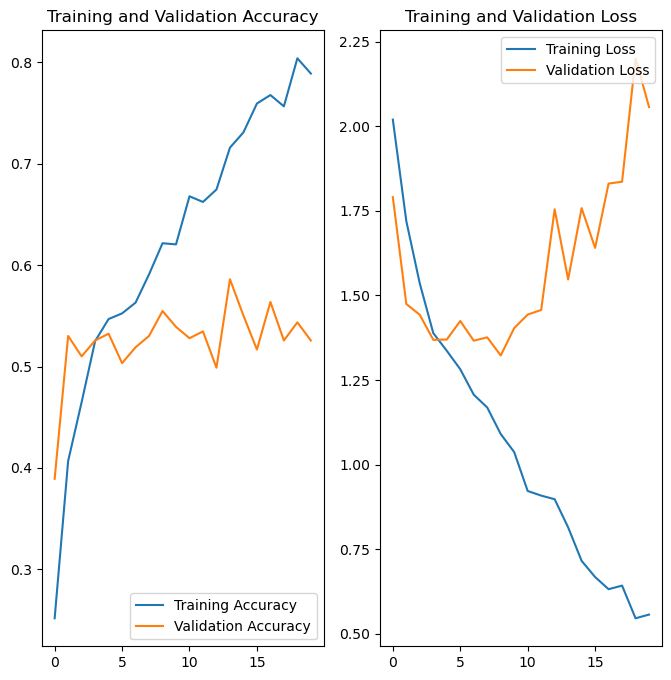

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
- The model shows a steady improvement in training accuracy, reaching around 80%, while validation accuracy remains relatively low at about 52%.

- The significant disparity between training and validation accuracy suggests that the model may be overfitting to the training data, meaning it has learned patterns specific to the training set rather than generalizing well to new data.

- To address this issue, data augmentation techniques will be implemented. Since the training dataset is relatively small, additional samples will be created by applying transformations such as horizontal and vertical flips, slight rotations, and other modifications. These augmented images will help enhance the model's ability to generalize to unseen data.ity.

#### we have decided to use keras.Sequential augmentation strategy

In [17]:
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])   

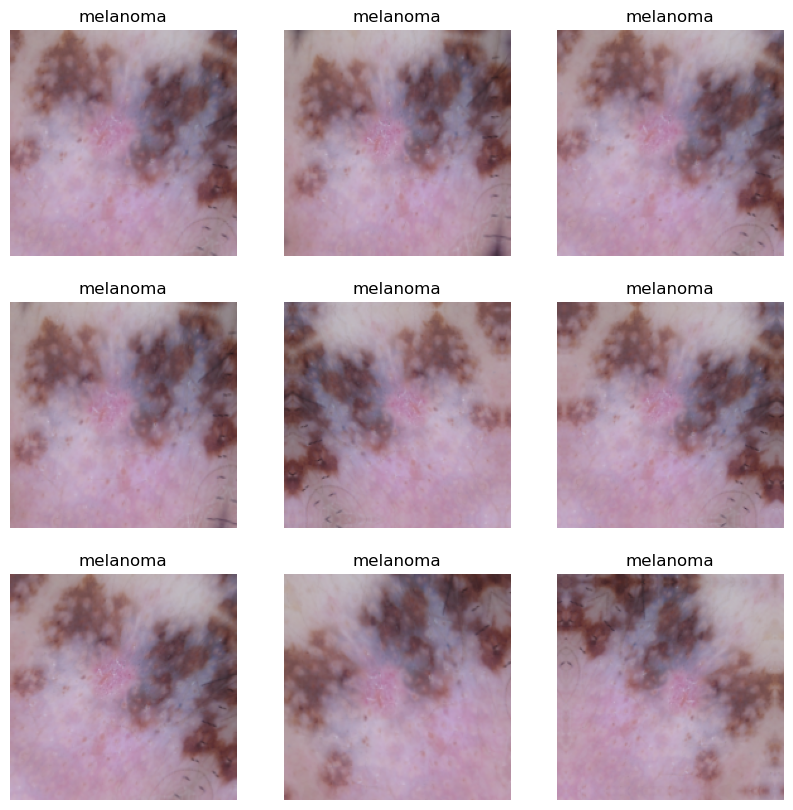

In [21]:
# Visualize augmented images
plt.figure(figsize=(10, 10))

# Take one batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Create the model

In [23]:
## we can use Dropout layer if there is an evidence of overfitting in your findings

model = tf.keras.Sequential([
    # Augmentation layer
    augmentation_data,

    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional block
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Second convolutional block
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Third convolutional block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Dropout layer to prevent overfitting
    layers.Dropout(0.2),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    # Output layer with logits for multi-class classification
    layers.Dense(target_classes)
])

### Compiling the model using adam optimizer

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [25]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.1655 - loss: 2.6083 - val_accuracy: 0.1924 - val_loss: 2.0579
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.2136 - loss: 2.0022 - val_accuracy: 0.2774 - val_loss: 1.9917
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.3232 - loss: 1.8409 - val_accuracy: 0.4251 - val_loss: 1.6760
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.4438 - loss: 1.6096 - val_accuracy: 0.4787 - val_loss: 1.5625
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.4505 - loss: 1.5430 - val_accuracy: 0.4944 - val_loss: 1.4606
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.4843 - loss: 1.4599 - val_accuracy: 0.5078 - val_loss: 1.3902
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.5065 - loss: 1.4323 - val_accuracy: 0.5347 - val_loss: 1.3370
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.5272 - loss: 1.3004 - val_accuracy: 0

### Visualizing the results

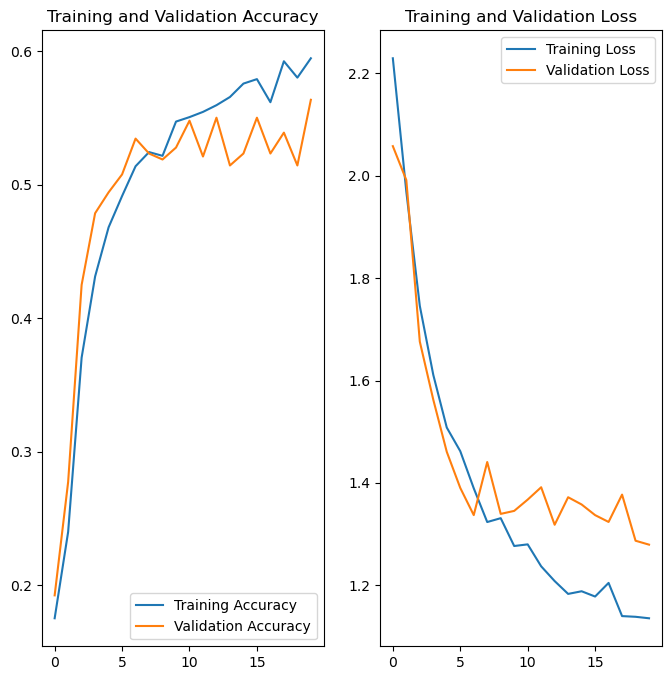

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()  

### Observations
- Applying data augmentation has successfully reduced overfitting, leading to better generalization. However, the training and validation accuracy now fall within a similar range, indicating potential underfitting.

- After 20 epochs, the model achieves an accuracy of 58% on the training set and around 56% on the validation set.

- Even with the steps taken to minimize overfitting, the model is still not achieving optimal performance on either the training or validation data. This suggests that the current model may be too simplistic or lacks the capacity to capture complex patterns within the dataset, which is a common characteristic of underfitting.

- To enhance performance, further modifications may be necessary, such as refining the model’s architecture or extending the training duration by increasing the number of epochse.

### Find the distribution of classes in the training dataset.

In [27]:
# Retrieve the image paths for all class labels (lesions)
image_paths = glob(os.path.join(data_dir_train, '*', '*.jpg'))

# Extract the class labels (lesions) from the directory structure
class_labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Print the total number of labels
print(f"Total number of class labels: {len(class_labels)}")

# Create a dictionary mapping image paths to class labels
image_to_label_mapping = {path: label for path, label in zip(image_paths, class_labels)}

# Print the first 5 entries in the dictionary
print("First 5 image-to-label mappings:")
print(list(image_to_label_mapping.items())[:5])

Total number of class labels: 2239
First 5 image-to-label mappings:
[('\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis'), ('\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025825.jpg', 'actinic keratosis'), ('\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025953.jpg', 'actinic keratosis'), ('\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\ISIC_0025957.jpg', 'actinic keratosis')]


In [28]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_to_label_mapping.items()), columns=['Path', 'Label'])
lesions_df.head()

,Path,Label
0,\Users\RYZEN\Desktop\CNN_assignment\Skin cance...,actinic keratosis
1,\Users\RYZEN\Desktop\CNN_assignment\Skin cance...,actinic keratosis
2,\Users\RYZEN\Desktop\CNN_assignment\Skin cance...,actinic keratosis
3,\Users\RYZEN\Desktop\CNN_assignment\Skin cance...,actinic keratosis
4,\Users\RYZEN\Desktop\CNN_assignment\Skin cance...,actinic keratosis


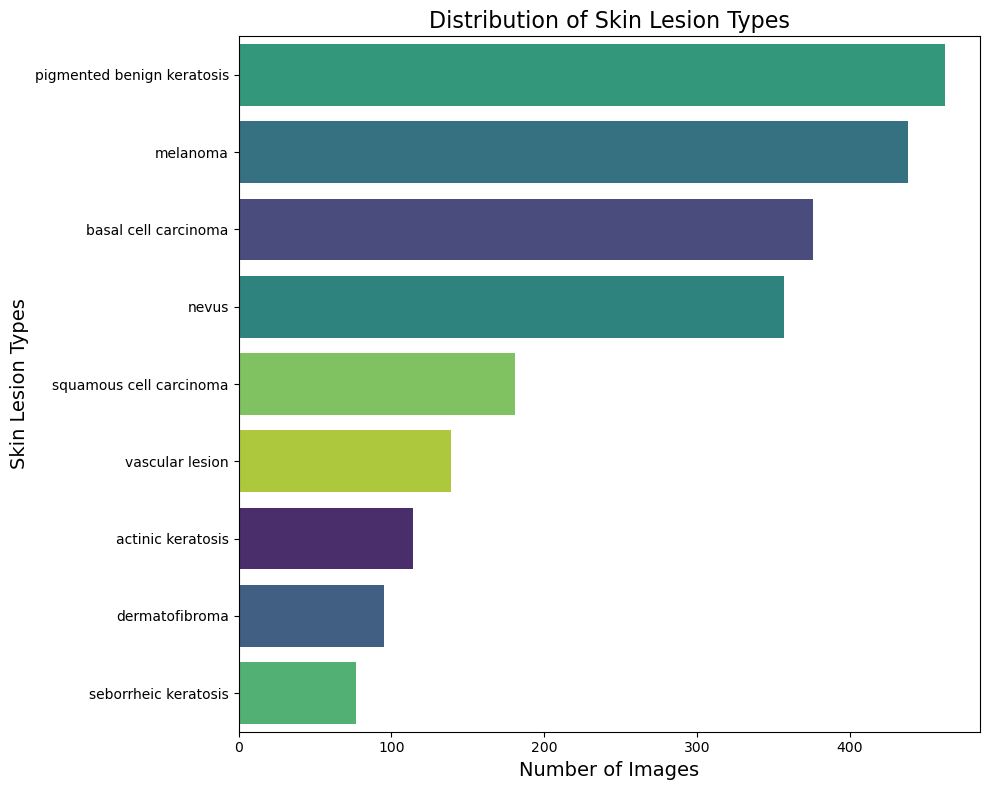

In [29]:
# Visualize the distribution of classes using a count plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.countplot(
    y='Label',
    hue="Label",
    data=lesions_df,
    order=lesions_df['Label'].value_counts().index,
    palette="viridis"  # Added a color palette
)
plt.title('Distribution of Skin Lesion Types', fontsize=16)
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.tight_layout()
plt.show()

In [30]:
# Inspect the distribution of classes in the dataset
class_distribution = lesions_df['Label'].value_counts()
print("Class distribution:")
print(class_distribution)

# Calculate and print the percentage distribution of each class
class_percentage = lesions_df[['Label']].value_counts(normalize=True) * 100
class_percentage_rounded = class_percentage.round(2)
print("\nClass percentage distribution:")
print(class_percentage_rounded)

Class distribution:
Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

Class percentage distribution:
Label                     
pigmented benign keratosis    20.63
melanoma                      19.56
basal cell carcinoma          16.79
nevus                         15.94
squamous cell carcinoma        8.08
vascular lesion                6.21
actinic keratosis              5.09
dermatofibroma                 4.24
seborrheic keratosis           3.44
Name: proportion, dtype: float64


### Observations 
#### Which class has the least number of samples?
- Seborrheic keratosis has the fewest samples, with only 77 images being the most prevalent in this category.

#### Which classes dominate the data in terms proportionate number of samples?

- Pigmented benign keratosis: 20.63% of the total data

- Melanoma: 19.56% of the total data

- Basal cell carcinoma: 16.79% of the total data

- Nevus: 15.94% of the total dataata.

These four categories account for the majority of the dataset, with the first two being the most prevalent.

### Rectify the class imbalance

In [31]:
## We are adding 500 samples per class to make sure that none of the classes are sparse.
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x275B58716D0>: 100%|█| 500/500 [00:01<00:00, 297.25 Samples


Initialised with 376 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x275BFB86690>: 100%|█| 500/500 [00:01<00:00, 317.27 Samples


Initialised with 95 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x275BFF71B50>: 100%|█| 500/500 [00:01<00:00, 303.80 Samples


Initialised with 438 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x27640401B80>: 100%|█| 500/500 [00:08<00:


Initialised with 357 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x275B6396270>: 100%|█| 500/500 [00:07<00:00, 65.65 Samples/


Initialised with 462 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x275A533BA70>: 100%|█| 500/500 [00:01<00:00, 318.30 Samples


Initialised with 77 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x27640455D90>: 100%|█| 500/500 [00:03<00:00, 137.47 Sample


Initialised with 181 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2763FEA1EE0>: 100%|█| 500/500 [00:01<00:00, 319.50 Samples


Initialised with 139 image(s) found.
Output directory set to \Users\RYZEN\Desktop\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2763FEA0DD0>: 100%|█| 500/500 [00:01<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2b2e4579-cd8b-4eee-bf92-516790749179.jpg',
 '\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6e5fd75b-5476-45ad-8900-c7fe7b719f54.jpg',
 '\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8edebbc3-a6a2-4f0a-a076-5a186249b1b6.jpg',
 '\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c44a4c8b-4660-4df5-9c85-dac5d3be1ec1.jpg',
 '\\Users\\RYZEN\\Desktop\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging C

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new 

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [37]:
# Inspecting the class distribution after adding 500 samples per label
class_counts = new_df['Label'].value_counts()
print("Class distribution after adding 500 samples per label:")
print(class_counts)

# Inspecting the class percentage distribution after adding 500 samples per label
class_percentage = new_df['Label'].value_counts(normalize=True) * 100
print("\nClass percentage distribution after adding 500 samples per label:")
print(round(class_percentage, 2))

Class distribution after adding 500 samples per label:
Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

Class percentage distribution after adding 500 samples per label:
Label
pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: proportion, dtype: float64


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model (make sure to include normalization)

In [41]:
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_classes)
])

#### Compile model using adam optimizer

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train Model

In [43]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 396ms/step - accuracy: 0.2791 - loss: 3.9106 - val_accuracy: 0.1151 - val_loss: 19.4150
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 366ms/step - accuracy: 0.4065 - loss: 1.5812 - val_accuracy: 0.1329 - val_loss: 11.0174
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 359ms/step - accuracy: 0.4400 - loss: 1.4628 - val_accuracy: 0.3593 - val_loss: 2.2279
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 360ms/step - accuracy: 0.4925 - loss: 1.3397 - val_accuracy: 0.5167 - val_loss: 1.3247
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 363ms/step - accuracy: 0.5229 - loss: 1.2625 - val_accuracy: 0.3445 - val_loss: 2.1556
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 359ms/step - accuracy: 0.5268 - loss: 1.2200 - val_accuracy: 0.4892 - val_loss: 1.3402
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 359ms/step - accuracy: 0.5658 - loss: 1.1153 - val_accuracy: 0.5301 - val_loss: 1.3756
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 359ms/step - accuracy: 0.5630 - loss:

### Visualization

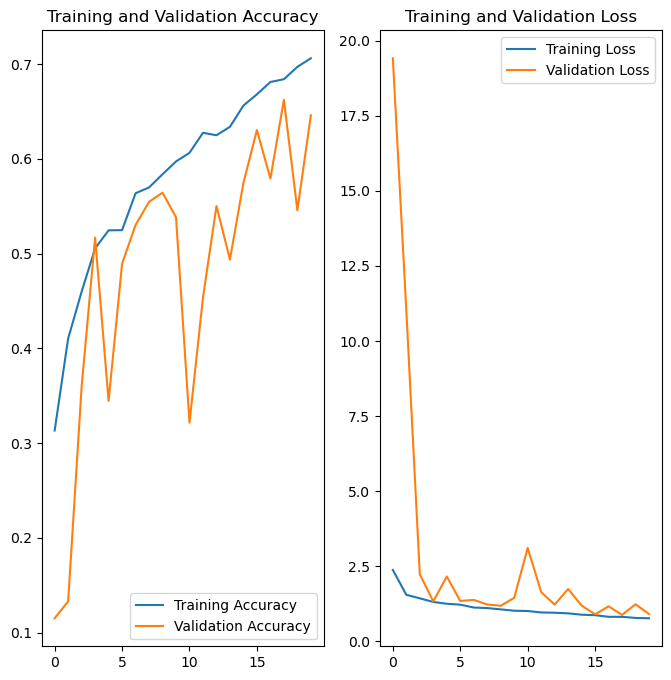

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,970,301 (45.66 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 7,980,052 (30.44 MB)

### observations

- Incorporating batch normalization into the model resulted in a modest increase in both training and validation accuracy.

- After 20 epochs, the model achieves an accuracy of 70% on the training set and around 64% on the validation set.

- To explore potential enhancements in accuracy, an alternative model will be developed without batch normalization for comparison.

#### Creating another model (without batch normalization)

In [46]:
# create the model
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_classes)
])

#### compiling the model using earlystopping callback

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is used to save the model or its weights at the point of the best validation accuracy
checkpoint = ModelCheckpoint(
    "model.keras",                    
    monitor="val_accuracy",           
    save_best_only=True,           
    mode="max",                       
    verbose=1                         
)

# EarlyStopping callback is used to stop training early if validation accuracy doesn't improve
earlystop = EarlyStopping(
    monitor="val_accuracy",           
    patience=5,                        
    mode="max",                        
    verbose=1                          
)

#### Training The model

In [48]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2303 - loss: 2.0359
Epoch 1: val_accuracy improved from -inf to 0.41722, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.2308 - loss: 2.0344 - val_accuracy: 0.4172 - val_loss: 1.5344
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4029 - loss: 1.5614
Epoch 2: val_accuracy improved from 0.41722 to 0.48107, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4031 - loss: 1.5610 - val_accuracy: 0.4811 - val_loss: 1.4169
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4707 - loss: 1.3825
Epoch 3: val_accuracy improved from 0.48107 to 0.48181, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.4707 - loss: 1.3825 - val_accuracy: 0.4818 - val_loss: 1.4130
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5206 - loss: 1.2786
Epoch 4: val_accuracy improved from 0.4

#### visualize the model results

In [49]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

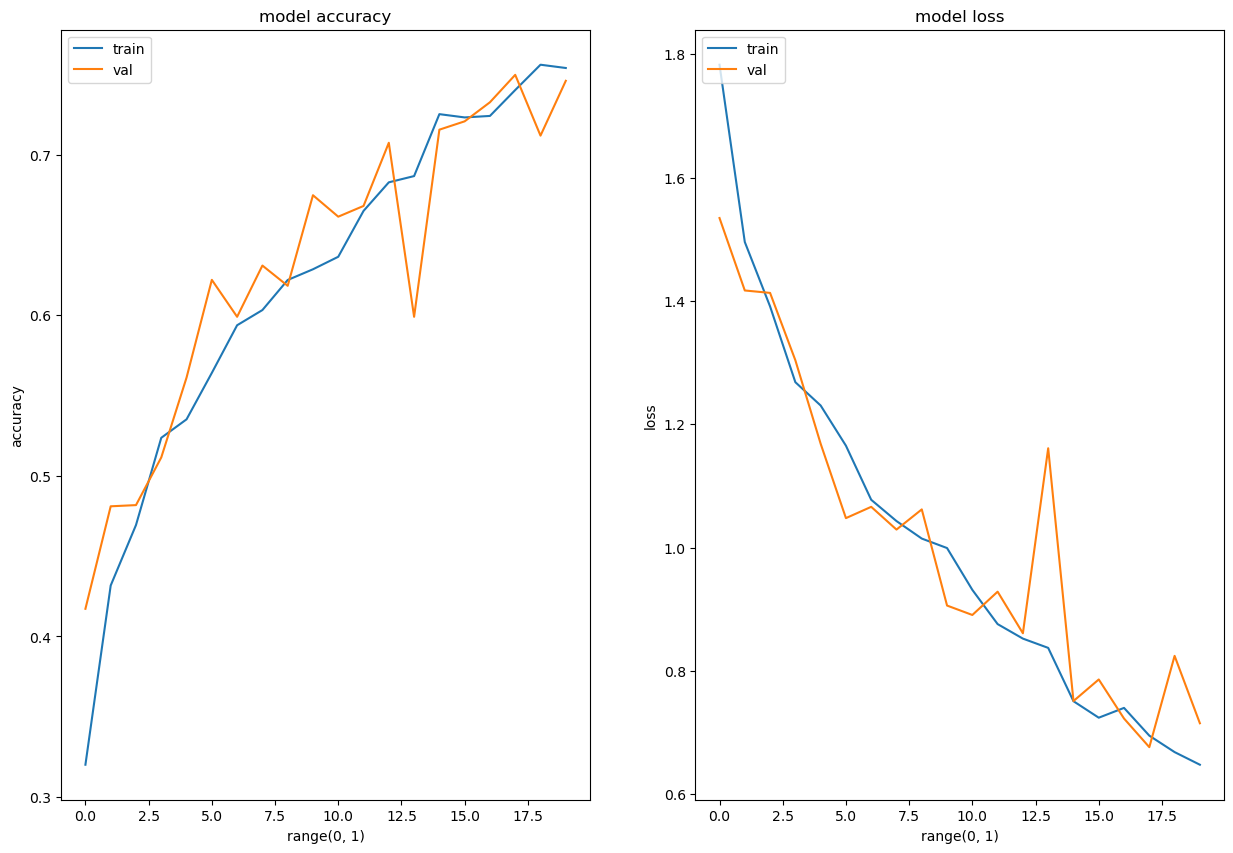

In [50]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Observations:

- The final model demonstrates a well-balanced performance, with no indications of underfitting or overfitting.

- Implementing class rebalancing has significantly improved the model’s accuracy on both the training and validation datasets..

- After 20 epochs, the final model achieves an accuracy of 75% on the training set and around 74% on the validation set.

- The minimal gap between training and validation accuracy highlights the strong generalization ability of the final CNN model.y.

- Incorporating batch normalization did not lead to any improvement in training or validation accuracy